In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, clustering
from tslearn.clustering import TimeSeriesKMeans

import warnings
warnings.filterwarnings('ignore')

c:\Users\BSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
homepath = "C:/A.PROJECTS/stockprediction/"

In [3]:
stock_prices = pd.read_csv(homepath + 'data/stock_prices_30_tickers.csv',parse_dates=['Date'], index_col='Date')

In [4]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """

    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [5]:
rets = compute_returns(stock_prices)

The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
Call dtw.try_import_c() to get more verbose errors.
See the documentation for alternative installation options.


Clusters and their Stocks (Columns):
Cluster 0: ['BAC', 'CSCO', 'CVX', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'ORCL', 'PEP', 'PFE', 'PG', 'T', 'TXN', 'V', 'WMT', 'XOM']
Cluster 1: ['TSLA']
Cluster 2: ['AAPL', 'ADBE', 'AMZN', 'AVGO', 'CRM', 'DIS', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA', 'QCOM']


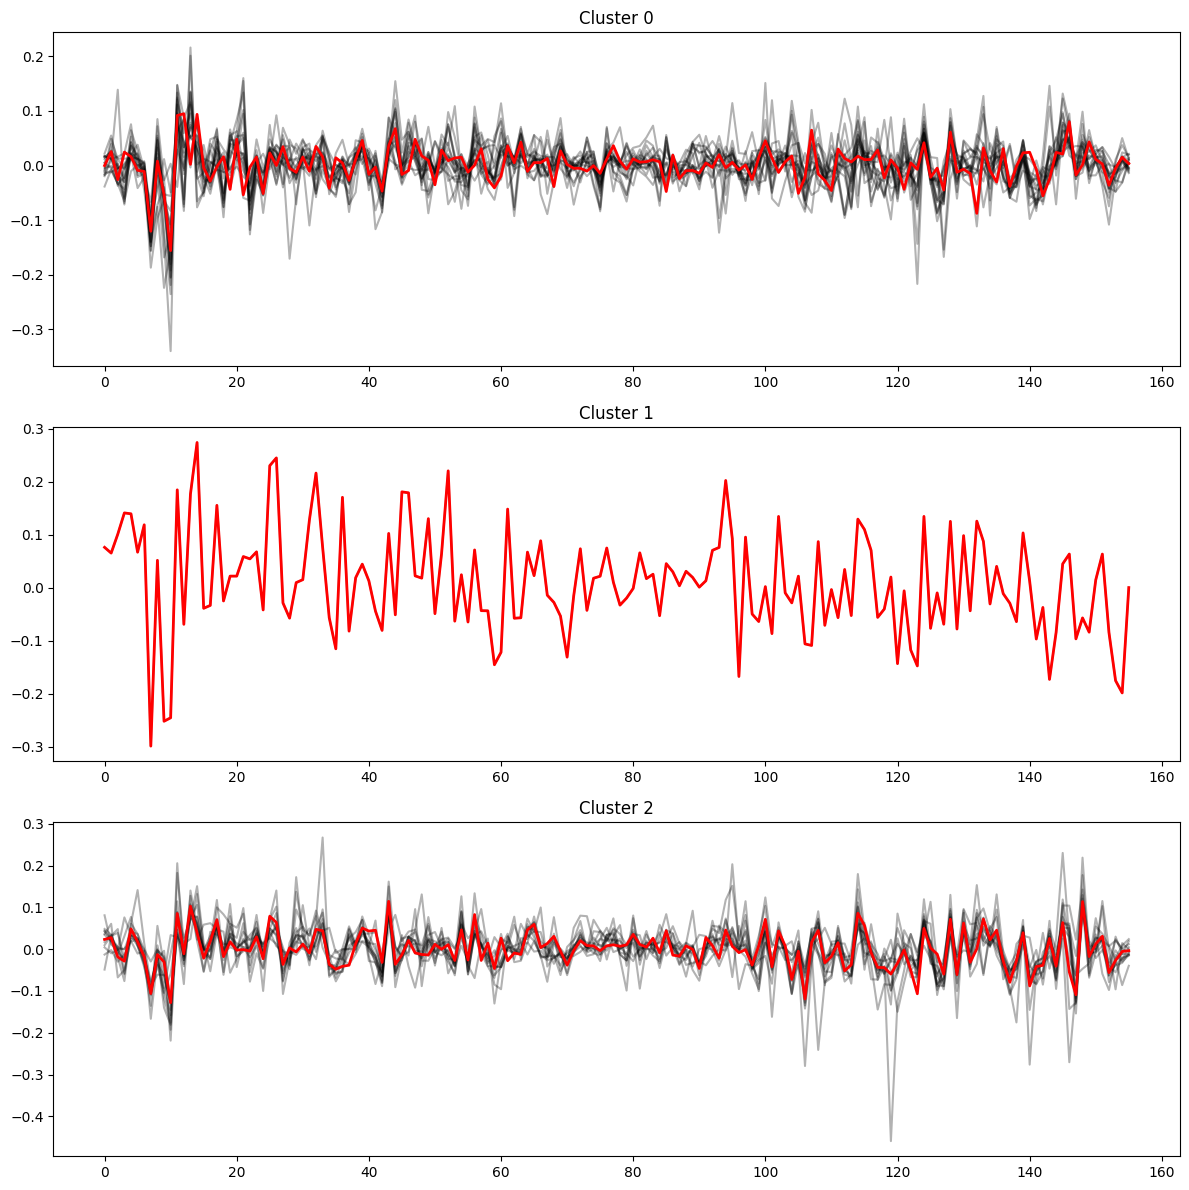

In [6]:
# Install necessary libraries:
# pip install dtaidistance tslearn matplotlib numpy pandas

import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd

# 1. Data Generation (Each COLUMN is a time series in this modified case)
def generate_time_series_dataframe(n_ts=20, sz=100):
    """
    Generates a Pandas DataFrame of time series data with stocks (or entities) as columns.

    Args:
        n_ts (int): Number of time series (columns).
        sz (int): Length of each time series (rows).

    Returns:
        pd.DataFrame: A DataFrame where each column is a time series.
    """
    np.random.seed(0)
    data = np.random.randn(sz, n_ts)  # sz is the number of time steps, n_ts is the number of stocks (columns)
    col_names = [f"Stock_{i}" for i in range(n_ts)]  # Column names for identification
    df = pd.DataFrame(data, columns=col_names)
    return df

# 2. Compute DTW Distance Matrix from DataFrame (MODIFIED for Columns)
def compute_dtw_distance_matrix_from_df(df):
    """
    Computes the DTW distance matrix from a Pandas DataFrame treating columns as time series.

    Args:
        df (pd.DataFrame): A DataFrame where each column represents a time series.

    Returns:
        np.ndarray: A DTW distance matrix.
    """
    series = df.values.T  # Transpose DataFrame to treat columns as time series
    return dtw.distance_matrix_fast(series)

# 3. Clustering Time Series Data by Columns (MODIFIED)
def cluster_time_series_with_kmeans(df, n_clusters=3):
    """
    Clusters time series from a Pandas DataFrame treating columns as time series.
    
    Args:
        df (pd.DataFrame): A DataFrame where each column is a time series (transposed for clustering).
        n_clusters (int): Number of clusters.

    Returns:
        tuple: A tuple containing:
            - labels: Cluster labels for each time series (as a NumPy array).
            - cluster_centers: Cluster centers (prototypes) as a NumPy array.
    """
    series = df.values.T.reshape(df.shape[1], df.shape[0], 1)  # Transpose and reshape for tslearn
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    labels = model.fit_predict(series)  # Cluster assignment
    return labels, model.cluster_centers_

# 4. Get Cluster Members by Column Name (MODIFIED)
def get_cluster_members(df, labels):
    """
    Groups DataFrame column names (stocks/entities) by their cluster labels.

    Args:
        df (pd.DataFrame): A DataFrame where each column represents a time series.
        labels (np.ndarray): Cluster labels as assigned by the clustering algorithm.

    Returns:
        dict: A dictionary where keys are cluster numbers and values are lists of column names.
    """
    clusters = {i: [] for i in range(len(set(labels)))}  # Create empty lists for each cluster
    for col_index, label in enumerate(labels):
        clusters[label].append(df.columns[col_index])  # Add column name based on cluster label
    return clusters

# 5. Plotting Utility (MODIFIED)
def plot_clusters(df, labels, cluster_centers):
    """
    Plots clusters by columns with their cluster centers.

    Args:
        df (pd.DataFrame): A DataFrame where each column is a time series.
        labels (np.ndarray): Cluster labels for each column (time series).
        cluster_centers (np.ndarray): Cluster center prototypes.
    """
    n_clusters = len(cluster_centers)
    plt.figure(figsize=(12, 4 * n_clusters))

    for cluster_id in range(n_clusters):
        plt.subplot(n_clusters, 1, cluster_id + 1)
        cluster_members = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        for member in cluster_members:
            plt.plot(df.iloc[:, member].values, "k-", alpha=0.3)  # Plot individual time series
        plt.plot(cluster_centers[cluster_id].ravel(), "r-", linewidth=2)  # Plot cluster center
        plt.title(f"Cluster {cluster_id}")
    
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Generate synthetic dataset as DataFrame (columns are stocks/entities)
    time_series_df = rets['weekly_log']

    # Compute the DTW distance matrix (optional for exploration)
    dtw_matrix = compute_dtw_distance_matrix_from_df(time_series_df)

    # Cluster the time series (by columns)
    n_clusters = 3  # Specify the number of clusters
    labels, cluster_centers = cluster_time_series_with_kmeans(time_series_df, n_clusters)

    # Get Cluster Members by Column Names
    cluster_members = get_cluster_members(time_series_df, labels)
    print("Clusters and their Stocks (Columns):")
    for cluster, members in cluster_members.items():
        print(f"Cluster {cluster}: {members}")

    # Plot clusters and their centers
    plot_clusters(time_series_df, labels, cluster_centers)


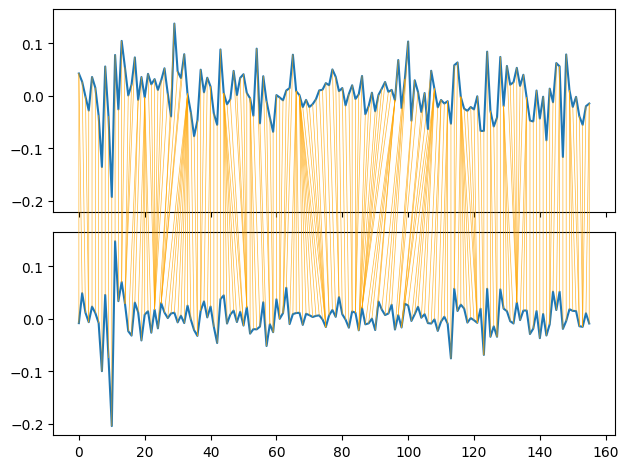

In [16]:
import numpy as np
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt  # Import matplotlib

# Two sample time series
series_1 = rets['weekly_log'].iloc[:,0].values
series_2 = rets['weekly_log'].iloc[:,20].values

# Calculate the warping path
path = dtw.warping_path(series_1, series_2)

# Visualize the DTW path
dtwvis.plot_warping(series_1, series_2, path)

# Ensure the plot is displayed (explicitly call plt.show())
plt.show()


In [18]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
from joblib import Parallel, delayed

# Generate random data (or use your own DataFrame)
np.random.seed(42)
num_columns = 100
num_rows = 200
data = np.random.rand(num_rows, num_columns)
df = pd.DataFrame(data, columns=[f'Series_{i}' for i in range(num_columns)])

# Function to compute DTW distance and warping path length for a single pair
def compute_dtw_for_pair(series_1, series_2):
    distance = dtw.distance(series_1, series_2)
    path = dtw.warping_path(series_1, series_2)
    path_length = len(path[0])  # Length of the warping path
    return distance, path_length

# Function to compute DTW measures for all pairs (optimized for parallel processing)
def compute_dtw_all_pairs(dataframe):
    num_columns = dataframe.shape[1]
    results = []
    
    # Precompute the column names and pairs to avoid repetition
    column_names = dataframe.columns
    pairs = [(i, j) for i in range(num_columns) for j in range(i + 1, num_columns)]
    
    # Use joblib to parallelize the DTW computations
    dtw_results = Parallel(n_jobs=-1)(  # -1 uses all available cores
        delayed(compute_dtw_for_pair)(
            dataframe.iloc[:, i].values, dataframe.iloc[:, j].values
        ) for i, j in pairs)
    
    # Collect results into a friendly format
    for (i, j), (distance, path_length) in zip(pairs, dtw_results):
        results.append({
            'Series_1': column_names[i],
            'Series_2': column_names[j],
            'DTW_Distance': distance,
            'Warping_Path_Length': path_length
        })
    
    return pd.DataFrame(results)

# Run the optimized computation
dtw_measures_df = compute_dtw_all_pairs(df)

# Display the results
print(dtw_measures_df)


       Series_1   Series_2  DTW_Distance  Warping_Path_Length
0      Series_0   Series_1      2.657952                    2
1      Series_0   Series_2      2.500263                    2
2      Series_0   Series_3      2.590826                    2
3      Series_0   Series_4      2.685718                    2
4      Series_0   Series_5      2.669995                    2
...         ...        ...           ...                  ...
4945  Series_96  Series_98      2.599731                    2
4946  Series_96  Series_99      2.531627                    2
4947  Series_97  Series_98      2.638952                    2
4948  Series_97  Series_99      2.471703                    2
4949  Series_98  Series_99      2.500492                    2

[4950 rows x 4 columns]
